<a href="https://colab.research.google.com/github/dhirajkrgupta/classical-models/blob/main/classicalML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install textstat
!pip install gdown  # only if not already installed

In [ ]:
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score,roc_curve,auc,matthews_corrcoef,cohen_kappa_score
from sklearn.preprocessing import StandardScaler
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from textstat import flesch_reading_ease, flesch_kincaid_grade

import matplotlib.pyplot as plt

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# **Step 1: Data Preparation**

In [ ]:
import json

data = []
with open("/content/SubtaskA.jsonl", "r", encoding="utf-8") as f:
    for i, line in enumerate(f, start=1):
        line = line.strip()
        if not line:  # skip empty lines
            continue
        try:
            record = json.loads(line)
            filtered = {k: record[k] for k in ("text", "label") if k in record}
            data.append(filtered)
        except json.JSONDecodeError as e:
            print(f"Error on line {i}: {e}")

df=pd.DataFrame(data)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_df.to_csv("/content/train.csv", index=False)
test_df.to_csv("/content/test.csv", index=False)




FileNotFoundError: [Errno 2] No such file or directory: '/content/SubtaskA.jsonl'

# **Step 3: Text Vectorization**


In [ ]:
def create_text_features(texts, max_features=5000, ngram_range=(1, 2), vectorizer_type='tfidf'):
    """
    Create text features using different vectorization methods
    """
    # Clean and preprocess texts
    cleaned_texts = []
    for text in texts:
        if text and isinstance(text, str) and not pd.isna(text):
            cleaned_texts.append(str(text).strip())
        else:
            cleaned_texts.append("")

    # Choose vectorizer
    if vectorizer_type == 'tfidf':
        vectorizer = TfidfVectorizer(
            max_features=max_features,
            ngram_range=ngram_range,
            stop_words='english',
            lowercase=True,
            strip_accents='ascii',
            min_df=2,
            max_df=0.95
        )
    elif vectorizer_type == 'count':
        vectorizer = CountVectorizer(
            max_features=max_features,
            ngram_range=ngram_range,
            stop_words='english',
            lowercase=True,
            strip_accents='ascii',
            min_df=2,
            max_df=0.95
        )

    text_features = vectorizer.fit_transform(cleaned_texts)
    return text_features, vectorizer

# **Step 4: Model Training Pipeline**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# compute matrix
def plotconfusino_matrix(conf_matrix):
    # define class labels
    classes = ["Human", "AI"]  # change to your own labels

    plt.figure(figsize=(6, 5))
    plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()

    # tick marks
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # put numbers in the cells
    thresh = conf_matrix.max() / 2
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(
                j, i, conf_matrix[i, j],
                ha="center", va="center",
                color="white" if conf_matrix[i, j] > thresh else "black"
            )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()


In [ ]:
class FlexibleAIHumanClassifier:
    """
    Flexible classifier that can use any sklearn classifier
    """

    def __init__(self, classifier_name='logistic', max_features=3000, ngram_range=(1, 2),
                 vectorizer_type='tfidf', use_scaling=True):

        self.vectorizer = None
        self.max_features = max_features
        self.ngram_range = ngram_range
        self.vectorizer_type = vectorizer_type
        self.classifier_name = classifier_name

        # Initialize the classifier based on name
        self.model = self._get_classifier(classifier_name)
    def _get_classifier(self, classifier_name):
        """Get classifier by name with optimized parameters"""
        classifiers = {
            'logistic': LogisticRegression(random_state=42, max_iter=1000),
            'random_forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
            'svm': LinearSVC( C=1.0,max_iter=1000,tol=1e-3,dual=False,random_state=42),
            'naive_bayes': GaussianNB(),
            'knn': KNeighborsClassifier(n_neighbors=5),
            'decision_tree': DecisionTreeClassifier(random_state=42),
            'extra_trees': ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1),
            'lda': LinearDiscriminantAnalysis(),
            'xgboost': XGBClassifier(random_state=42, n_jobs=-1),
            'mlp': MLPClassifier(random_state=42)
        }

        if classifier_name not in classifiers:
            raise ValueError(f"Classifier '{classifier_name}' not supported. Available: {list(classifiers.keys())}")

        return classifiers[classifier_name]

    def prepare_features(self, texts, fit_transform=True):
      if fit_transform:
          text_features, self.vectorizer = create_text_features(
              texts, self.max_features, self.ngram_range, self.vectorizer_type
          )
      else:
          # use the already-fitted vectorizer to just transform new texts
          cleaned_texts = [
              str(t).strip() if t and isinstance(t, str) and not pd.isna(t) else ""
              for t in texts
          ]
          text_features = self.vectorizer.transform(cleaned_texts)

      # Convert sparse to dense if the classifier requires it
      if isinstance(self.model, (GaussianNB, LinearDiscriminantAnalysis)):
          text_features = text_features.toarray()

      return text_features


    def train(self, X_train, y_train):
        """Train the classifier"""
        # Prepare features
        print(len(X_train))
        X_train_features = self.prepare_features(X_train, fit_transform=True)
        print(X_train_features.shape)
        # Train the model
        self.model.fit(X_train_features, y_train)
        return self

    def predict(self, X_test):
        """Make predictions"""
        # Prepare features
        X_test_features = self.prepare_features(X_test, fit_transform=False)

        # Predict
        predictions = self.model.predict(X_test_features)

        # Get probabilities if available
        try:
            probabilities = self.model.predict_proba(X_test_features)
        except:
            probabilities = None

        return predictions, probabilities

    def evaluate(self, X_test, y_test):
        """Evaluate the model"""
        predictions, probabilities = self.predict(X_test)

        accuracy = accuracy_score(y_test, predictions)
        report = classification_report(y_test, predictions, target_names=['AI', 'Human'])
        precision = precision_score(y_test, predictions)
        recall = recall_score(y_test, predictions)
        f1 = f1_score(y_test, predictions)
        mcc=matthews_corrcoef(y_test, predictions)
        kappa_score=cohen_kappa_score(y_test, predictions)
        conf_matrix = confusion_matrix(y_test, predictions)
        plotconfusino_matrix(conf_matrix)

        # Calculate AUC if probabilities are available
        auc_score = None
        if probabilities is not None:
            auc_score = roc_auc_score(y_test, probabilities[:, 1])
            # Plot ROC curve
            fpr, tpr, thresholds = roc_curve(y_test, probabilities[:, 1])
            plt.figure()
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (ROC)')
            plt.legend(loc="lower right")
            plt.show()

        return {
            'accuracy': accuracy,
            'auc_score': auc_score,
            'precision':precision,
            'recall':recall,
            'f1_score':f1,
            'classification_report': report,
            'confusion_matrix': conf_matrix,
            'mcc':mcc,
            'cohen_kappa_score':kappa_score,
            'predictions': predictions,
            'probabilities': probabilities
        }

# **Step 6: Usage Example**

In [ ]:
def train_single_classifier(classifier_name='random_forest'):
    """
    Train a single classifier
    """
    # Load data
    train_df = pd.read_csv("/content/train.csv")


    # Split data
    X = train_df['text']
    y = train_df['label']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    \
    # Train classifier
    classifier = FlexibleAIHumanClassifier(classifier_name=classifier_name)
    classifier.train(X_train, y_train)

    # Evaluate
    results = classifier.evaluate(X_test, y_test)

    print(f"Results for {classifier_name}:")
    print(f"Accuracy: {results['accuracy']:.4f}")
    if results['auc_score']:
        print(f"AUC Score: {results['auc_score']:.4f}")
    print(f"Precision: {results['precision']:.4f}")
    print(f"Recall: {results['recall']:.4f}")
    print(f"F1 Score: {results['f1_score']:.4f}")
    print(f"MCC: {results['mcc']:.4f}")
    print(f"Cohen Kappa Score: {results['cohen_kappa_score']:.4f}")
    print("\nClassification Report:")
    print(results['classification_report'])

    return classifier, results

**Logistic Regression**

81214
(81214, 3000)


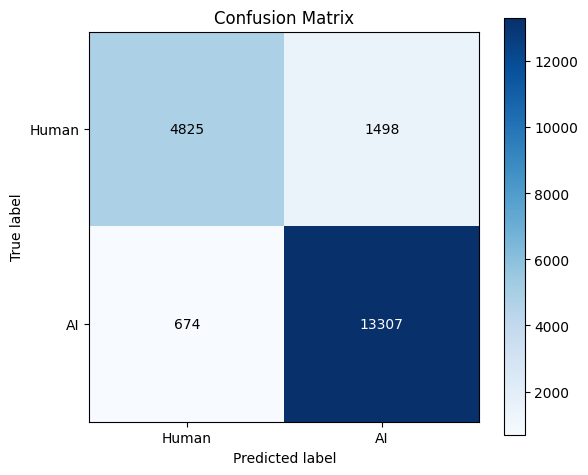

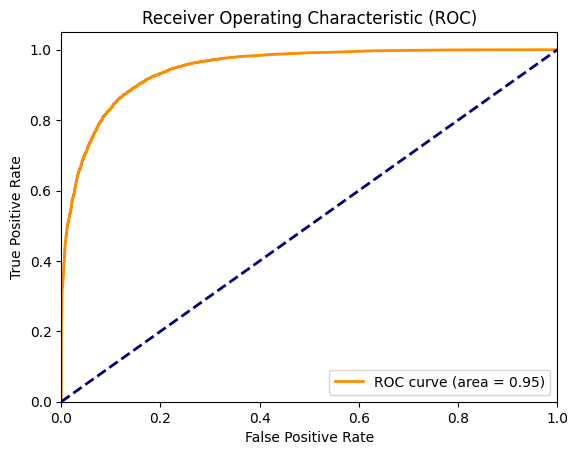

Results for logistic:
Accuracy: 0.8930
AUC Score: 0.9475
Precision: 0.8988
Recall: 0.9518
F1 Score: 0.9245
MCC: 0.7449
Cohen Kappa Score: 0.7413

Classification Report:
              precision    recall  f1-score   support

          AI       0.88      0.76      0.82      6323
       Human       0.90      0.95      0.92     13981

    accuracy                           0.89     20304
   macro avg       0.89      0.86      0.87     20304
weighted avg       0.89      0.89      0.89     20304



In [ ]:
logistic,logistic_results= train_single_classifier(classifier_name='logistic');

**MLP**

81214
(81214, 3000)


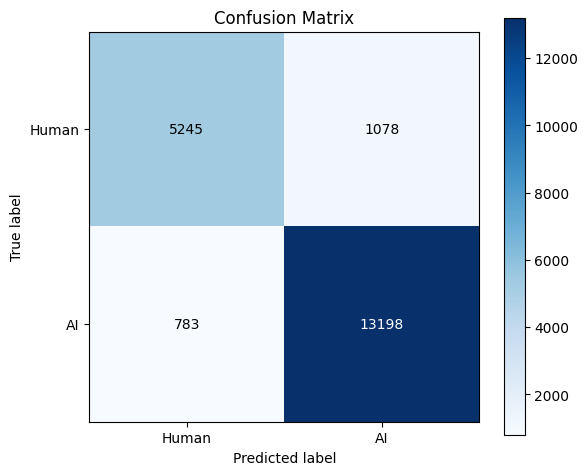

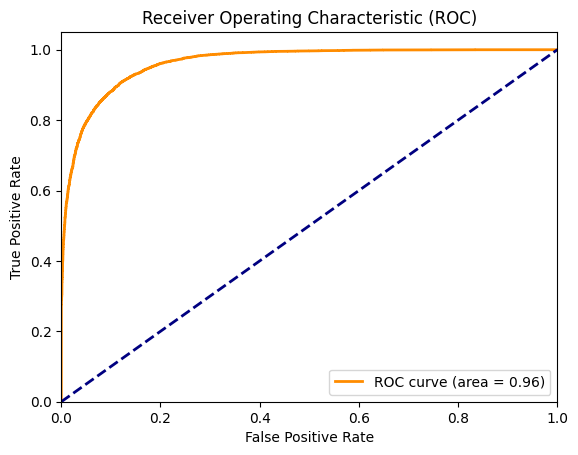

Results for mlp:
Accuracy: 0.9083
AUC Score: 0.9632
Precision: 0.9245
Recall: 0.9440
F1 Score: 0.9341
MCC: 0.7840
Cohen Kappa Score: 0.7835

Classification Report:
              precision    recall  f1-score   support

          AI       0.87      0.83      0.85      6323
       Human       0.92      0.94      0.93     13981

    accuracy                           0.91     20304
   macro avg       0.90      0.89      0.89     20304
weighted avg       0.91      0.91      0.91     20304



In [ ]:
mlp,mlp_results= train_single_classifier(classifier_name='mlp');

**Random forest**

81214
(81214, 3000)


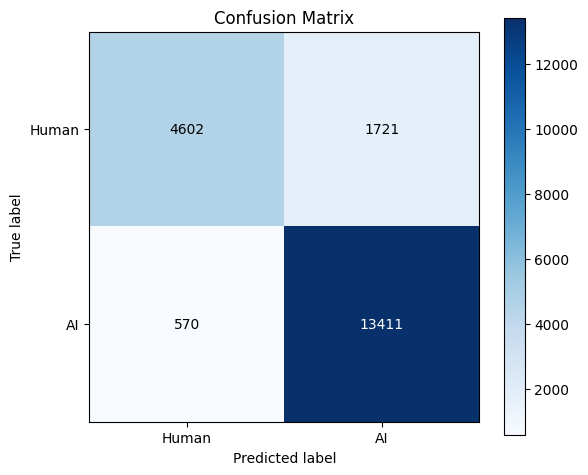

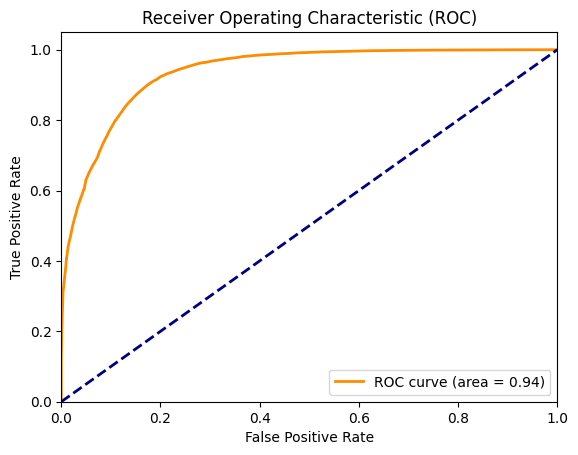

Results for random_forest:
Accuracy: 0.8872
AUC Score: 0.9364
Precision: 0.8863
Recall: 0.9592
F1 Score: 0.9213
MCC: 0.7302
Cohen Kappa Score: 0.7231

Classification Report:
              precision    recall  f1-score   support

          AI       0.89      0.73      0.80      6323
       Human       0.89      0.96      0.92     13981

    accuracy                           0.89     20304
   macro avg       0.89      0.84      0.86     20304
weighted avg       0.89      0.89      0.88     20304



In [ ]:
random_forest,random_forest_results= train_single_classifier(classifier_name='random_forest');

**Naive Bayes**

81214
(81214, 3000)


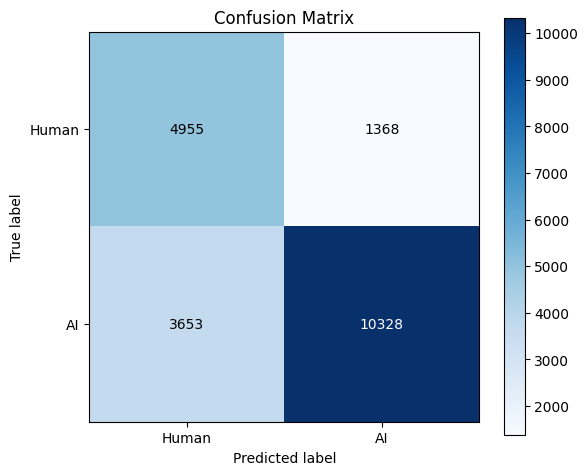

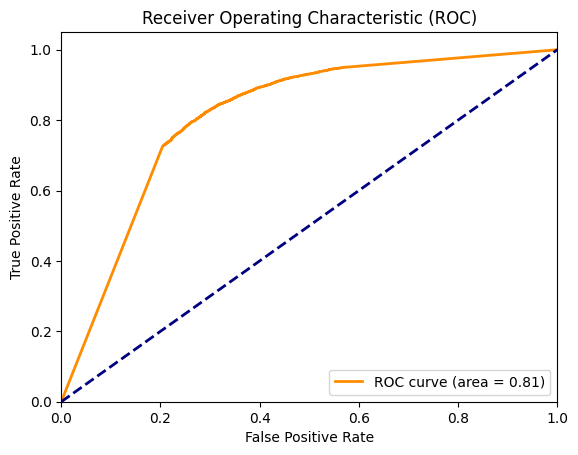

Results for naive_bayes:
Accuracy: 0.7527
AUC Score: 0.8116
Precision: 0.8830
Recall: 0.7387
F1 Score: 0.8045
MCC: 0.4895
Cohen Kappa Score: 0.4753

Classification Report:
              precision    recall  f1-score   support

          AI       0.58      0.78      0.66      6323
       Human       0.88      0.74      0.80     13981

    accuracy                           0.75     20304
   macro avg       0.73      0.76      0.73     20304
weighted avg       0.79      0.75      0.76     20304



In [ ]:
naive_bayes,naive_bayes_results= train_single_classifier(classifier_name='naive_bayes')


KNN

81214
(81214, 3000)


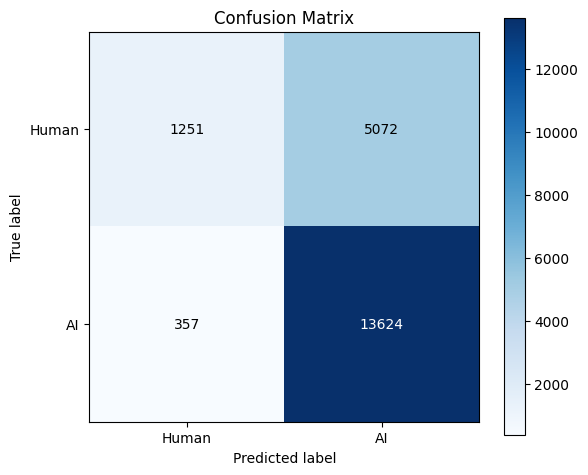

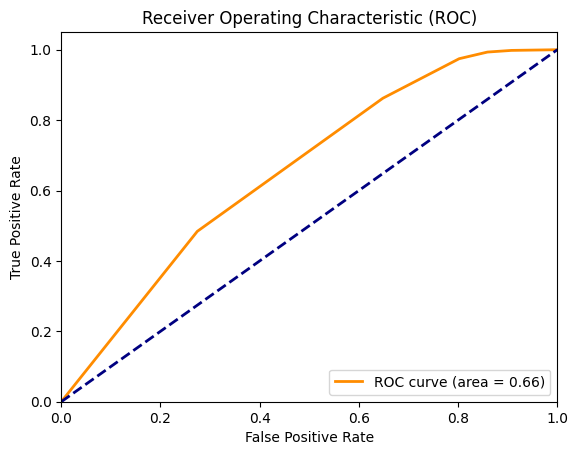

Results for knn:
Accuracy: 0.7326
AUC Score: 0.6561
Precision: 0.7287
Recall: 0.9745
F1 Score: 0.8339
MCC: 0.2955
Cohen Kappa Score: 0.2165

Classification Report:
              precision    recall  f1-score   support

          AI       0.78      0.20      0.32      6323
       Human       0.73      0.97      0.83     13981

    accuracy                           0.73     20304
   macro avg       0.75      0.59      0.57     20304
weighted avg       0.74      0.73      0.67     20304



In [ ]:
knn,knn_results= train_single_classifier(classifier_name='knn')


**Decision Tree**

81214
(81214, 3000)


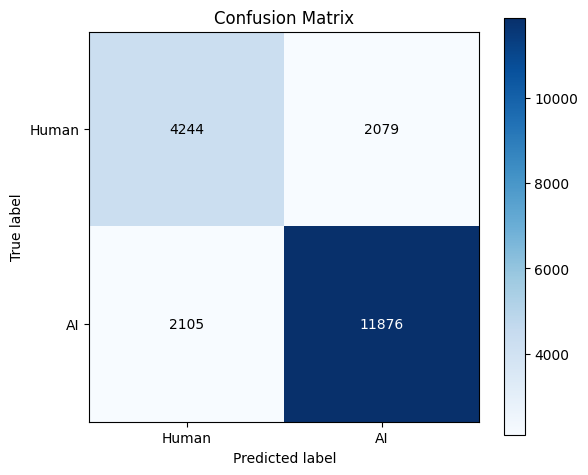

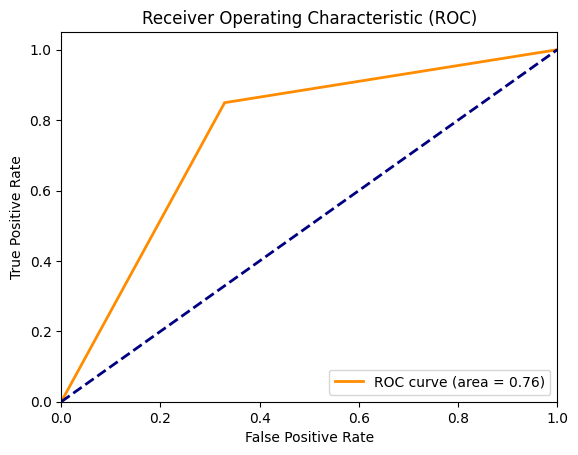

Results for decision_tree:
Accuracy: 0.7939
AUC Score: 0.7601
Precision: 0.8510
Recall: 0.8494
F1 Score: 0.8502
MCC: 0.5201
Cohen Kappa Score: 0.5201

Classification Report:
              precision    recall  f1-score   support

          AI       0.67      0.67      0.67      6323
       Human       0.85      0.85      0.85     13981

    accuracy                           0.79     20304
   macro avg       0.76      0.76      0.76     20304
weighted avg       0.79      0.79      0.79     20304



In [ ]:
decision_tree,decision_tree_results= train_single_classifier(classifier_name='decision_tree')


**Extra Trees**

81214
(81214, 3000)


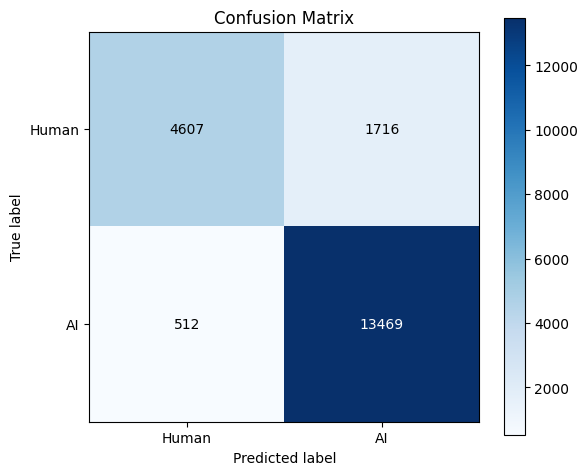

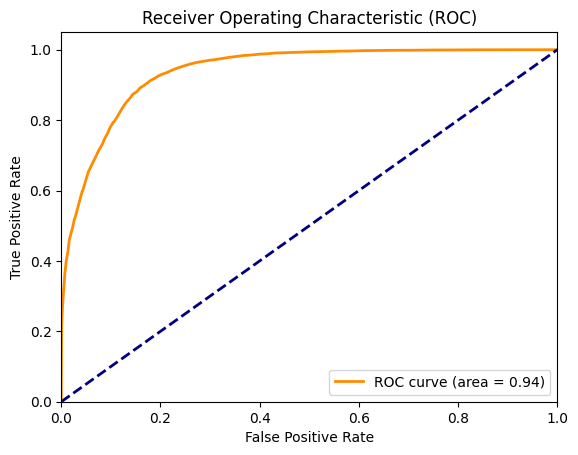

Results for extra_trees:
Accuracy: 0.8903
AUC Score: 0.9385
Precision: 0.8870
Recall: 0.9634
F1 Score: 0.9236
MCC: 0.7380
Cohen Kappa Score: 0.7301

Classification Report:
              precision    recall  f1-score   support

          AI       0.90      0.73      0.81      6323
       Human       0.89      0.96      0.92     13981

    accuracy                           0.89     20304
   macro avg       0.89      0.85      0.86     20304
weighted avg       0.89      0.89      0.89     20304



In [ ]:
extra_trees,extra_trees_results= train_single_classifier(classifier_name='extra_trees')

**LDA**

In [ ]:
lda,lda_results= train_single_classifier(classifier_name='lda')


81214
(81214, 3000)


**xgboost**

81214
(81214, 3000)


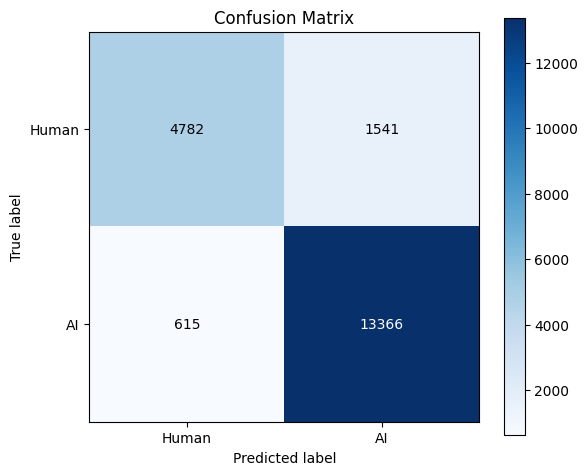

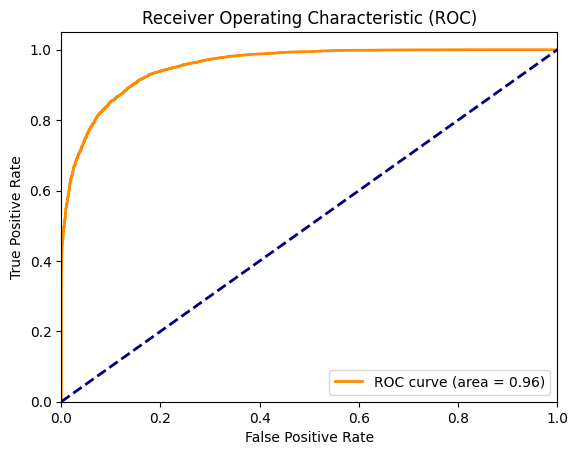

Results for xgboost:
Accuracy: 0.8938
AUC Score: 0.9551
Precision: 0.8966
Recall: 0.9560
F1 Score: 0.9254
MCC: 0.7467
Cohen Kappa Score: 0.7421

Classification Report:
              precision    recall  f1-score   support

          AI       0.89      0.76      0.82      6323
       Human       0.90      0.96      0.93     13981

    accuracy                           0.89     20304
   macro avg       0.89      0.86      0.87     20304
weighted avg       0.89      0.89      0.89     20304



In [ ]:
xgboost,xgboost_results= train_single_classifier(classifier_name='xgboost')


***SVM***

81214
(81214, 3000)


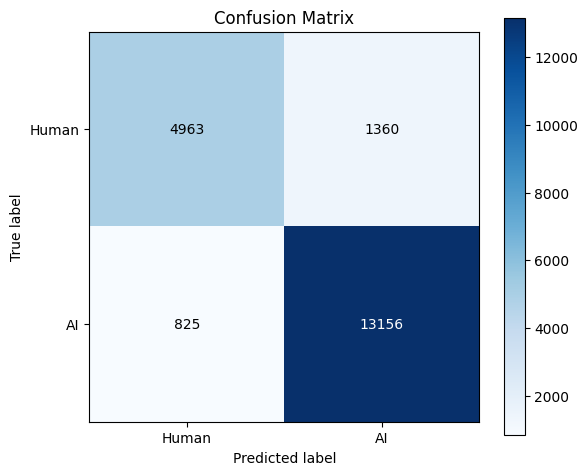

Results for svm:
Accuracy: 0.8924
Precision: 0.9063
Recall: 0.9410
F1 Score: 0.9233
MCC: 0.7446
Cohen Kappa Score: 0.7431

Classification Report:
              precision    recall  f1-score   support

          AI       0.86      0.78      0.82      6323
       Human       0.91      0.94      0.92     13981

    accuracy                           0.89     20304
   macro avg       0.88      0.86      0.87     20304
weighted avg       0.89      0.89      0.89     20304



In [ ]:
svm,svm_results= train_single_classifier(classifier_name='svm')